In [1]:
import torch
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

In [3]:
# This function will show 20 images from the dataset
def show_images(datset, num_samples=20, cols=4):
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(img[0])


In [4]:
import torch.nn.functional as F

# Research paper uses linear beta schedule to change beta over time. 

def linear_beta_schedule(timesteps, start=0.0001, end=0.02): 
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# Test function for forward process

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


T = 300
betas = linear_beta_schedule(timesteps=T)

# Using cumprod function to take cumulative product to find alpha

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [5]:
# The maximum batch size we could use using local GPU was 26, so we used 202592 datapoints so that epochs can run properly.

import torch.utils.data as data_utils

indices = torch.arange(202592)

In [6]:
import numpy as np
image_size = 64
mini_batch = 8
channels = 3


data_transforms = [
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Transforms data into tensor and scales them between (0, 1) 
    transforms.Lambda(lambda y: (y * 2) - 1) # Scale images between [-1, 1] 
    ]
data_transform = transforms.Compose(data_transforms)
image_datasets = torchvision.datasets.ImageFolder(root = '/Datadata/train', transform = data_transform)
dataset = data_utils.Subset(image_datasets, indices)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=mini_batch, shuffle=True, num_workers=0)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda y: (y + 1) / 2),
        transforms.Lambda(lambda y: y.permute(1, 2, 0)), # converting image from channel height width to height width channel
        transforms.Lambda(lambda y: y * 255.),
        transforms.Lambda(lambda y: y.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))


In [7]:
print(len(dataset))

202592


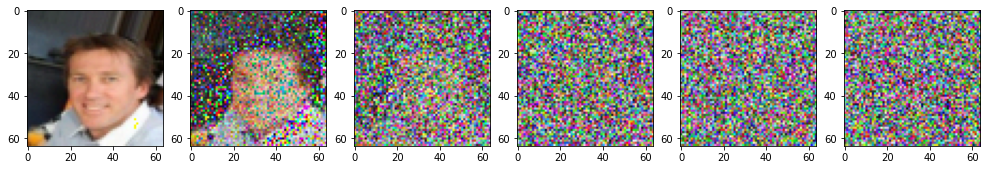

In [8]:
# Forward process on a single dataset
image = next(iter(dataloader))[0]

plt.figure(figsize=(20,20))
plt.axis('off')
num_images = 6
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images)+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [9]:
from torch import nn
import math
from torch import nn, einsum

##############################################################################################################################

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g
    
    

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
    
    
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


###############################################################################################################################
class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)



class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

    
###############################################################################################################################


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class U_net(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 512, 1024)
        up_channels = (1024, 512, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
      
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)
        
        
##############################################################################################################################
        dim_in = down_channels[0]
        dim_out = up_channels[-1]
        mid_dim = 1024
        self.attention_down = Residual(PreNorm(dim_in, LinearAttention(dim_in)))
        self.attention_up = Residual(PreNorm(dim_out, LinearAttention(dim_out)))
        self.attention_mid = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        
##############################################################################################################################

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
       
        x = self.conv0(x)
        
        x = self.attention_down(x)
    
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
            
        x = self.attention_mid(x)
    
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        x = self.attention_up(x)
        return self.output(x)

model = U_net()

In [10]:
print("Number of weights: ", sum(p.numel() for p in model.parameters()))

model

Number of weights:  83847011


U_net(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): C

In [19]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    # Using mean squared error loss
    return F.mse_loss(noise, noise_pred)

In [20]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    img_size = image_size
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    num_images = 6
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images), int((i)/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()            

In [21]:
# Using adam optimizer
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
# Code to empty GPU cache
import gc



for i in range(50):
    gc.collect()
    torch.cuda.empty_cache()

0
Epoch 0 | step 000 Loss: 0.03345825523138046 


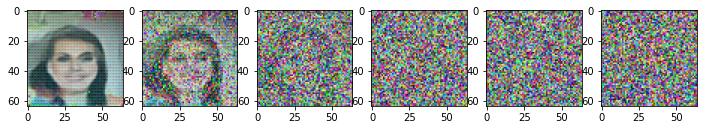

Epoch 0 | step 000 Loss: 0.03345825523138046 
Epoch 0 | step 1000 Loss: 0.029791247099637985 


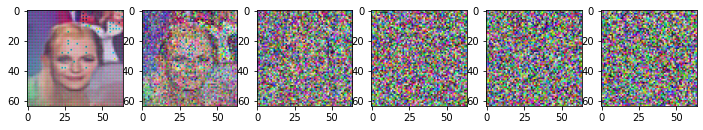

Epoch 0 | step 2000 Loss: 0.10184690356254578 


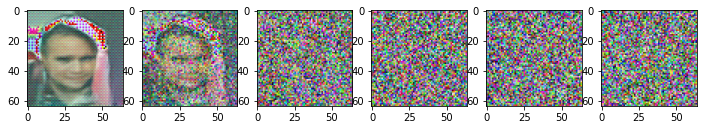

Epoch 0 | step 3000 Loss: 0.04816173017024994 


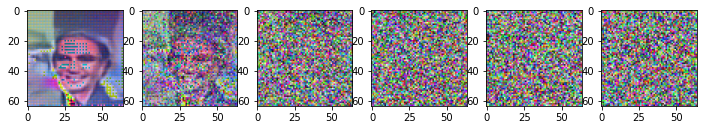

Epoch 0 | step 4000 Loss: 0.034390613436698914 


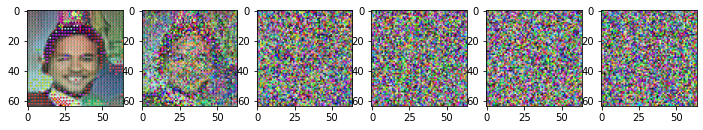

Epoch 0 | step 5000 Loss: 0.02399199828505516 


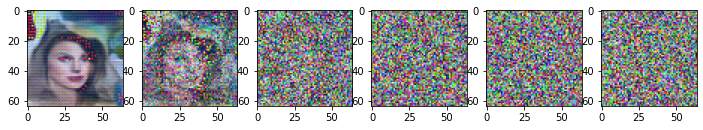

Epoch 0 | step 6000 Loss: 0.010759707540273666 


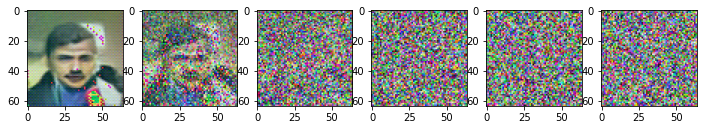

Epoch 0 | step 7000 Loss: 0.057290997356176376 


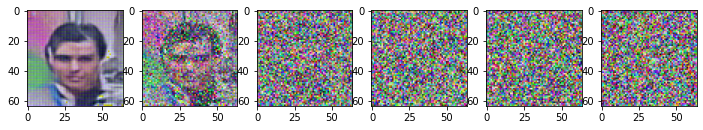

Epoch 0 | step 8000 Loss: 0.14443182945251465 


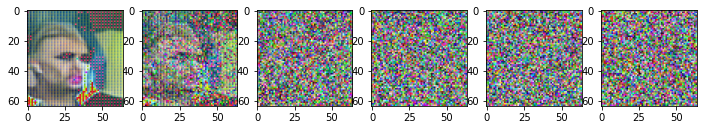

Epoch 0 | step 9000 Loss: 0.02061990648508072 


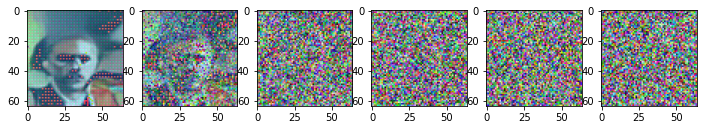

Epoch 0 | step 10000 Loss: 0.04080384597182274 


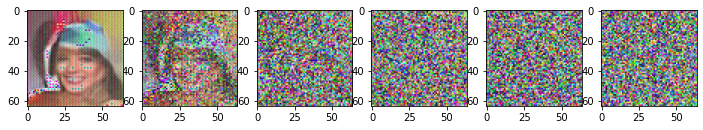

Epoch 0 | step 11000 Loss: 0.08726634830236435 


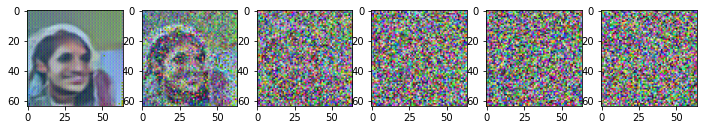

Epoch 0 | step 12000 Loss: 0.04703263193368912 


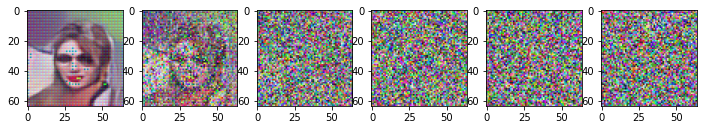

Epoch 0 | step 13000 Loss: 0.023447461426258087 


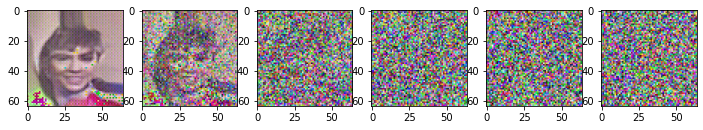

Epoch 0 | step 14000 Loss: 0.0353635773062706 


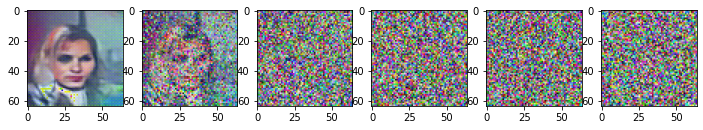

Epoch 0 | step 15000 Loss: 0.05860384553670883 


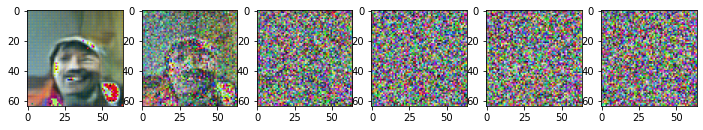

Epoch 0 | step 16000 Loss: 0.01248115673661232 


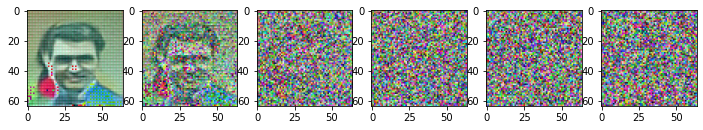

Epoch 0 | step 17000 Loss: 0.057484447956085205 


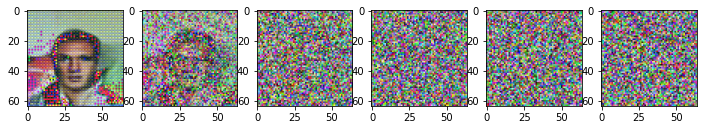

Epoch 0 | step 18000 Loss: 0.031375952064991 


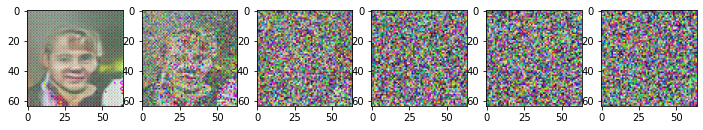

Epoch 0 | step 19000 Loss: 0.016170023009181023 


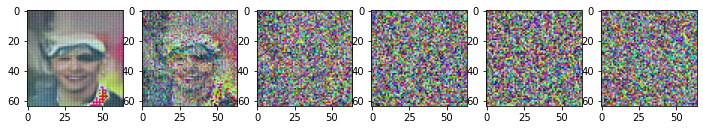

Epoch 0 | step 20000 Loss: 0.03159049153327942 


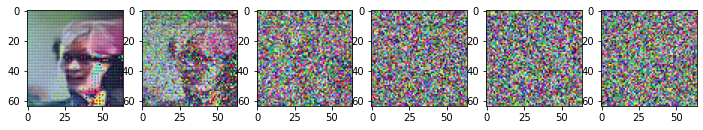

Epoch 0 | step 21000 Loss: 0.05337224528193474 


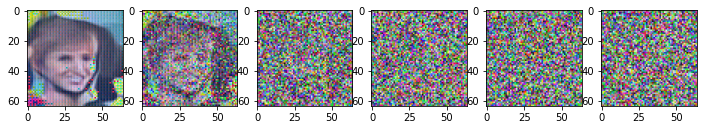

Epoch 0 | step 22000 Loss: 0.045939795672893524 


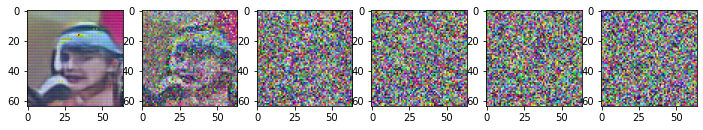

Epoch 0 | step 23000 Loss: 0.03530564531683922 


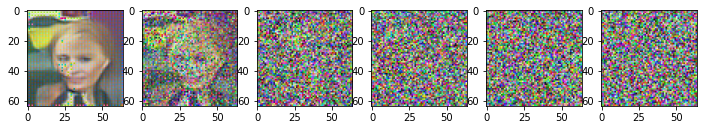

Epoch 0 | step 24000 Loss: 0.011343803256750107 


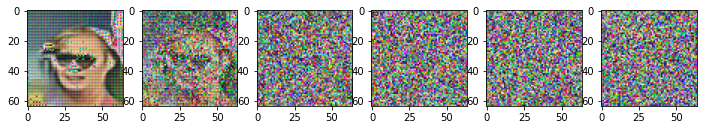

Epoch 0 | step 25000 Loss: 0.021109720692038536 


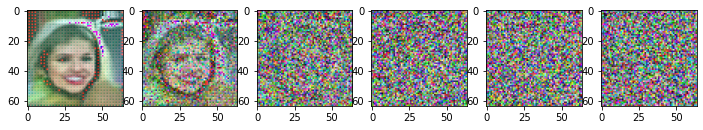

1
Epoch 1 | step 000 Loss: 0.10860815644264221 


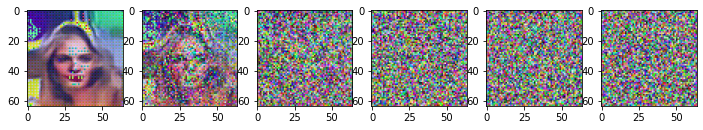

Epoch 1 | step 1000 Loss: 0.01931268721818924 


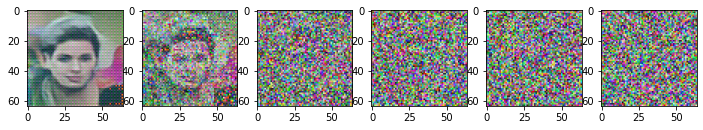

Epoch 1 | step 2000 Loss: 0.025347869843244553 


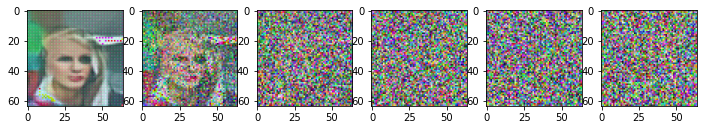

Epoch 1 | step 3000 Loss: 0.039963703602552414 


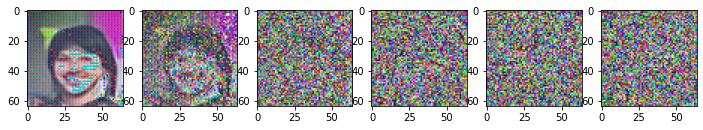

Epoch 1 | step 4000 Loss: 0.008870653808116913 


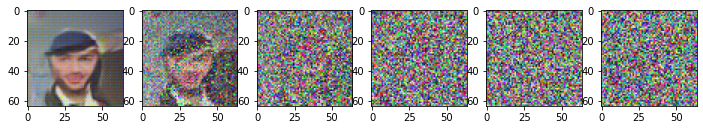

KeyboardInterrupt: 

In [24]:
model.to(device)
optimizer = Adam(model.parameters(), lr=0.00005) # Learning rate = 5 x 10^-5
epochs = 100

for epoch in range(epochs):
    print(epoch)
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (mini_batch,), device=device).long()
        loss = get_loss(model, batch[0], t)
        #if step % 10 == 0:
        # Saving model after every 10 steps
        #torch.save(model, 'model_final.pth')
        loss_value = loss.item()
        '''
        if step % 10 == 0:
            with open('loss/loss.csv','a') as fd:
                fd.write(str(step) + ',' + str(loss_value) + '\n')
        '''
        if step % 1000 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            #sample_plot_image()

In [29]:
torch.save(model, 'attention_model_newhead.pth')

In [23]:
model = torch.load('attention_model_newhead.pth')